# Predictive Maintenance — KPI Analysis (Industrial Standard)

## Goal
Compute reliability and maintenance KPIs used in industrial operations:
- Failure Rate
- MTBF (Mean Time Between Failures)
- MTTR (Mean Time To Repair) *(requires repair duration; approximated if unavailable)*
- RUL (Remaining Useful Life)
- Cost KPIs (repair cost, expected risk cost)
- Maintenance threshold recommendations (hours_since_maintenance)

Dataset:
- 24,042 records
- 20 machines
- 4 types (CNC, Pump, Compressor, Robotic Arm)

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
df = pd.read_csv(
    "../../data/raw/predictive_maintenance.csv",
    parse_dates=["timestamp"]
)

df.head()

,timestamp,machine_id,machine_type,vibration_rms,temperature_motor,current_phase_avg,pressure_level,rpm,operating_mode,hours_since_maintenance,ambient_temp,rul_hours,failure_within_24h,failure_type,estimated_repair_cost
0,2024-01-01 00:00:00,1,CNC,0.81,49.51,5.10,23.6,860.9,idle,273.80,13.9,61.00,0,none,0
1,2024-01-01 00:03:00,1,CNC,0.75,40.58,5.30,23.6,899.6,idle,273.85,10.2,60.95,0,none,0
2,2024-01-01 00:21:00,1,CNC,0.71,49.70,NaN,21.3,862.7,idle,274.15,13.6,60.65,0,none,0
3,2024-01-01 00:45:00,1,CNC,0.76,43.04,4.79,22.6,870.4,idle,274.55,13.4,60.25,0,none,0
4,2024-01-01 00:54:00,1,CNC,0.88,41.39,4.44,22.2,881.9,idle,274.70,10.8,60.10,0,none,0


### Basic checks

In [3]:
print("Shape:", df.shape)
print("Machines:", df["machine_id"].nunique())
print("Time range:", df["timestamp"].min(), "->", df["timestamp"].max())

df["failure_within_24h"].value_counts(dropna=False)

Shape: (24042, 15)
Machines: 20
Time range: 2024-01-01 00:00:00 -> 2024-01-14 23:59:38


failure_within_24h
0    20482
1     3560
Name: count, dtype: int64

### Create time grain (daily) for industrial KPIs

In [4]:
df["day"] = df["timestamp"].dt.floor("D")

## KPI 1 — Failure Rate
### Failure rate global

In [5]:
failure_rate_global = df["failure_within_24h"].mean()
failure_rate_global

np.float64(0.14807420347724815)

### Failure rate by machine

In [6]:
failure_rate_machine = (
    df.groupby("machine_id")["failure_within_24h"]
    .mean()
    .sort_values(ascending=False)
)

failure_rate_machine.head(10)

machine_id
13    0.239366
10    0.234642
7     0.233051
4     0.230500
19    0.223359
20    0.205106
11    0.187937
1     0.156879
15    0.152174
12    0.151414
Name: failure_within_24h, dtype: float64

### Plot: Failure rate top machines

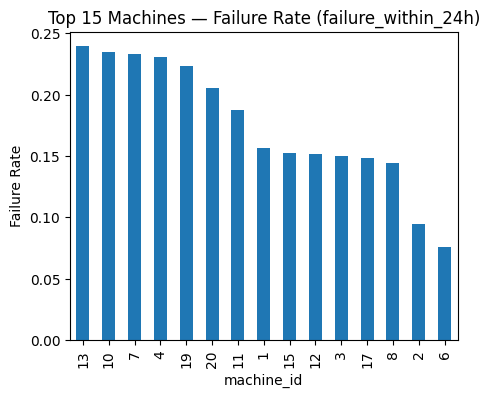

In [8]:
plt.figure(figsize=(5,4))
failure_rate_machine.head(15).plot(kind="bar")
plt.title("Top 15 Machines — Failure Rate (failure_within_24h)")
plt.ylabel("Failure Rate")
plt.show()

### Failure rate by machine type

In [13]:
failure_rate_type = (
    df.groupby("machine_type")["failure_within_24h"]
    .mean()
    .sort_values(ascending=False)
)

failure_rate_type

machine_type
Compressor     0.159987
Pump           0.149329
Robotic Arm    0.142429
CNC            0.140475
Name: failure_within_24h, dtype: float64

## KPI 2
### RUL by machine (mean + min)

In [14]:
rul_stats = df.groupby("machine_id").agg(
    rul_mean=("rul_hours", "mean"),
    rul_min=("rul_hours", "min"),
    rul_p10=("rul_hours", lambda x: np.nanpercentile(x, 10)),
).sort_values("rul_mean")

rul_stats.head(10)

,rul_mean,rul_min,rul_p10
machine_id,,,
8,17.115128,0.5,0.5
17,18.628312,0.5,0.5
2,18.642417,0.5,0.5
6,18.940555,0.5,0.5
5,20.446492,0.5,0.5
1,22.386904,0.5,0.5
16,23.426784,0.5,0.5
18,23.589120,0.5,0.5
15,25.895376,0.5,0.5


### Plot: Lowest RUL machines

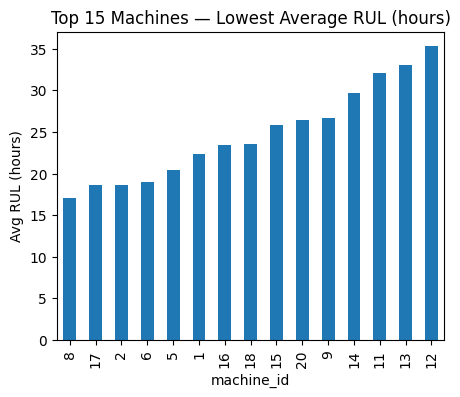

In [16]:
plt.figure(figsize=(5,4))
rul_stats["rul_mean"].head(15).plot(kind="bar")
plt.title("Top 15 Machines — Lowest Average RUL (hours)")
plt.ylabel("Avg RUL (hours)")
plt.show()

## KPI 3 — Cost KPIs (Repair cost + expected risk cost)
### Avg repair cost by machine + type

In [17]:
cost_machine = (
    df.groupby("machine_id")["estimated_repair_cost"]
    .mean()
    .sort_values(ascending=False)
)

cost_type = (
    df.groupby("machine_type")["estimated_repair_cost"]
    .mean()
    .sort_values(ascending=False)
)

cost_machine.head(10), cost_type

(machine_id
 13    1055.309425
 7     1049.233898
 4     1032.829097
 19    1010.681159
 11     860.028846
 10     860.023038
 20     791.245957
 12     691.254576
 17     681.466835
 8      673.795548
 Name: estimated_repair_cost, dtype: float64,
 machine_type
 Compressor     656.601369
 Pump           639.638371
 Robotic Arm    578.336498
 CNC            559.916456
 Name: estimated_repair_cost, dtype: float64)

### Expected daily risk cost

In [21]:
risk_by_machine = df.groupby("machine_id").apply(
    lambda g: (g["failure_within_24h"].mean() * g["estimated_repair_cost"].mean())
).sort_values(ascending=False)

risk_by_machine.head(10)

C:\Users\denos\AppData\Local\Temp\ipykernel_14044\1701888625.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  risk_by_machine = df.groupby("machine_id").apply(


machine_id
13    252.605342
7     244.524849
4     238.066654
19    225.744641
10    201.797214
20    162.289596
11    161.631295
12    104.665834
17    101.275928
8      97.208756
dtype: float64

## KPI 4 — MTBF (Mean Time Between Failures)
### Function MTBF

In [23]:
def compute_mtbf_hours(group: pd.DataFrame) -> float:
    g = group.sort_values("timestamp")
    fail_times = g.loc[g["failure_within_24h"] == 1, "timestamp"].dropna().unique()
    if len(fail_times) < 2:
        return np.nan
    fail_times = pd.to_datetime(fail_times)
    diffs = np.diff(fail_times) / np.timedelta64(1, "h")
    return float(np.mean(diffs))

mtbf = df.groupby("machine_id").apply(compute_mtbf_hours).sort_values()
mtbf.head(10)

C:\Users\denos\AppData\Local\Temp\ipykernel_14044\3084386053.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mtbf = df.groupby("machine_id").apply(compute_mtbf_hours).sort_values()


machine_id
6     0.242096
5     0.255616
14    0.259890
9     0.266479
16    0.271591
18    0.277059
1     0.328810
15    0.370820
8     0.418383
2     0.451937
dtype: float64

### Plot MTBF (lowest first = worst)

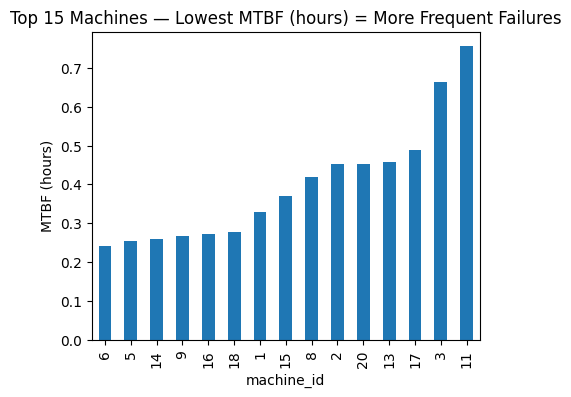

In [25]:
plt.figure(figsize=(5,4))
mtbf.dropna().head(15).plot(kind="bar")
plt.title("Top 15 Machines — Lowest MTBF (hours) = More Frequent Failures")
plt.ylabel("MTBF (hours)")
plt.show()

## KPI 5 — MTTR (Mean Time To Repair)

### MTTR proxy (cost-based)

In [26]:
mttr_proxy = (
    df.groupby("machine_id")["estimated_repair_cost"]
    .mean()
    .sort_values(ascending=False) / 100
)

mttr_proxy.head(10)

machine_id
13    10.553094
7     10.492339
4     10.328291
19    10.106812
11     8.600288
10     8.600230
20     7.912460
12     6.912546
17     6.814668
8      6.737955
Name: estimated_repair_cost, dtype: float64

### Plot MTTR proxy

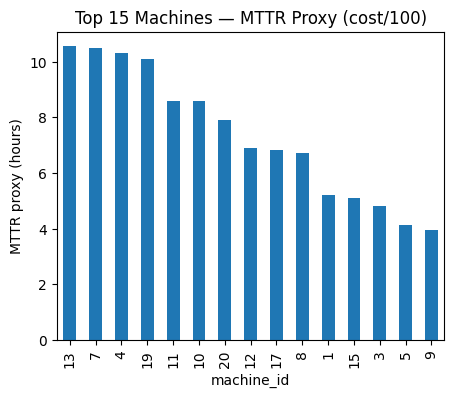

In [28]:
plt.figure(figsize=(5,4))
mttr_proxy.head(15).plot(kind="bar")
plt.title("Top 15 Machines — MTTR Proxy (cost/100)")
plt.ylabel("MTTR proxy (hours)")
plt.show()

## KPI 6 — Maintenance threshold recommendation (hours_since_maintenance)
### Bin maintenance age

In [29]:
bins = [0, 50, 100, 200, 300, 400, 600, 1000, np.inf]
labels = ["0-50","50-100","100-200","200-300","300-400","400-600","600-1000","1000+"]

df["maint_age_bin"] = pd.cut(df["hours_since_maintenance"], bins=bins, labels=labels, right=False)

maint_risk = df.groupby("maint_age_bin")["failure_within_24h"].mean()
maint_risk

C:\Users\denos\AppData\Local\Temp\ipykernel_14044\3074723411.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  maint_risk = df.groupby("maint_age_bin")["failure_within_24h"].mean()


maint_age_bin
0-50        0.131331
50-100      0.116279
100-200     0.180112
200-300     0.043542
300-400     0.175083
400-600     0.253446
600-1000         NaN
1000+            NaN
Name: failure_within_24h, dtype: float64

### Plot risk by maintenance age bin

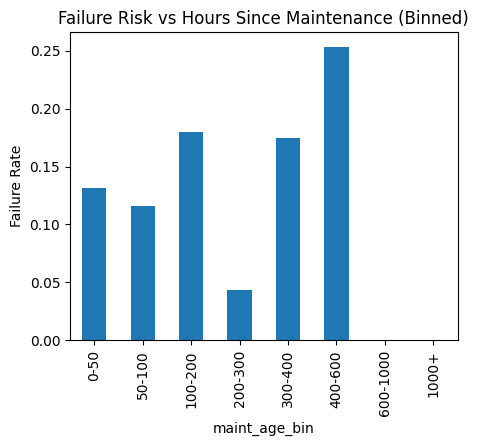

In [31]:
plt.figure(figsize=(5,4))
maint_risk.plot(kind="bar")
plt.title("Failure Risk vs Hours Since Maintenance (Binned)")
plt.ylabel("Failure Rate")
plt.show()

## KPI 7 — Machine Criticality Score (MCS)
### Build criticality table

In [32]:
kpi_table = pd.DataFrame({
    "failure_rate": failure_rate_machine,
    "avg_repair_cost": df.groupby("machine_id")["estimated_repair_cost"].mean(),
    "avg_rul": df.groupby("machine_id")["rul_hours"].mean(),
    "mtbf_hours": mtbf
})

# Normalize metrics for scoring
def minmax(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min())

kpi_table["score_failure"] = minmax(kpi_table["failure_rate"]).fillna(0)
kpi_table["score_cost"] = minmax(kpi_table["avg_repair_cost"]).fillna(0)
kpi_table["score_low_rul"] = (1 - minmax(kpi_table["avg_rul"])).fillna(0)  # low RUL = high score
kpi_table["score_low_mtbf"] = (1 - minmax(kpi_table["mtbf_hours"])).fillna(0)  # low MTBF = high score

kpi_table["criticality_score"] = (
    0.4 * kpi_table["score_failure"] +
    0.3 * kpi_table["score_cost"] +
    0.2 * kpi_table["score_low_rul"] +
    0.1 * kpi_table["score_low_mtbf"]
)

kpi_table.sort_values("criticality_score", ascending=False).head(10)

,failure_rate,avg_repair_cost,avg_rul,mtbf_hours,score_failure,score_cost,score_low_rul,score_low_mtbf,criticality_score
machine_id,,,,,,,,,
13,0.239366,1055.309425,33.031376,0.458593,1.000000,1.000000,0.273118,0.735974,0.828221
7,0.233051,1049.233898,35.644932,0.799350,0.962841,0.992964,0.153759,0.320406,0.745818
20,0.205106,791.245957,26.419064,0.452719,0.798419,0.694173,0.575097,0.743137,0.716953
4,0.230500,1032.829097,37.661849,1.007582,0.947830,0.973964,0.061648,0.066459,0.690297
10,0.234642,860.023038,35.388951,0.836947,0.972202,0.773828,0.165450,0.274554,0.681574
19,0.223359,1010.681159,39.011739,0.864390,0.905815,0.948313,0.000000,0.241087,0.670929
8,0.144270,673.795548,17.115128,0.418383,0.440466,0.558147,1.000000,0.785011,0.622132
17,0.148615,681.466835,18.628312,0.488336,0.466027,0.567032,0.930894,0.699700,0.612669
11,0.187937,860.028846,32.093934,0.755362,0.697397,0.773834,0.315930,0.374051,0.611700
